In [1]:
# --- Functions
import xarray as xr # read netcdf-files
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures
from scipy.signal import find_peaks
import numpy as np
import glob
import os
import pandas as pd

## First look of the CALIPSO data
(from Haochi)

The files contain, binned on temperature.:
- supercooled-count
- total count

Variants of the datasets:
- 2009_2023: all the years form 2008 to 2023
- 2022: only 2022
Months:
- FM: February - March
- JFMA: January - April
- DJMA: December - April

The region is 70-78.5 degrees and longitudes 6 to 25, ocean only. Data divided into:
- whole region
- North part
- south part

In [2]:
# --- Paths
cal_path = '/home/ninalar/Documents/MC2/Calipso_fromHaochi/'

# calipso file names:
jfma_files = ['SLF_2009_2023_JFMA_whole.nc',
         'SLF_2009_2023_JFMA_north.nc',
         'SLF_2009_2023_JFMA_south.nc',
         'SLF_top_2009_2023_JFMA_whole.nc',
         'SLF_top_2009_2023_JFMA_north.nc',
         'SLF_top_2009_2023_JFMA_south.nc']
fm_files = ['SLF_2009_2023_FM_whole.nc',
         'SLF_2009_2023_FM_north.nc',
         'SLF_2009_2023_FM_south.nc',
         'SLF_top_2009_2023_FM_whole.nc',
         'SLF_top_2009_2023_FM_north.nc',
         'SLF_top_2009_2023_FM_south.nc']
djfma_files = ['SLF_2009_2023_DJFMA_whole.nc',
         'SLF_2009_2023_DJFMA_north.nc',
         'SLF_2009_2023_DJFMA_south.nc',
         'SLF_top_2009_2023_DJFMA_whole.nc',
         'SLF_top_2009_2023_DJFMA_north.nc',
         'SLF_top_2009_2023_DJFMA_south.nc']
oneyear_files = ['SLF_2022_JFMA_whole.nc',
         'SLF_2022_JFMA_north.nc',
         'SLF_2022_JFMA_south.nc',
         'SLF_2022_DJMFA_whole.nc',        
         'SLF_2022_DJMFA_north.nc',    
         'SLF_2022_DJMFA_south.nc',
         'SLF_2022_FM_whole.nc',
         'SLF_2022_FM_north.nc',
         'SLF_2022_FM_south.nc',
         'SLF_top_2022_JFMA_whole.nc',
         'SLF_top_2022_JFMA_north.nc',
         'SLF_top_2022_JFMA_south.nc',
         'SLF_top_2022_DJMFA_whole.nc',        
         'SLF_top_2022_DJMFA_north.nc',    
         'SLF_top_2022_DJMFA_south.nc',
         'SLF_top_2022_FM_whole.nc',
         'SLF_top_2022_FM_north.nc',
         'SLF_top_2022_FM_south.nc']

print(cal_path + jfma_files[0])

/home/ninalar/Documents/MC2/Calipso_fromHaochi/SLF_2009_2023_JFMA_whole.nc


In [3]:
def create_ds_with_attrs(file, path):
    """Function to create xarray dataset with attributes extracted from filename
      Parameters
    ----------
    file
        name of NetCDF file to open
    path
        path to where file is located

    Returns
    -------
    ds
        Xarray dataset with data from file and attributes (region, months, cloudtop) from filename

    """
    #set up xarray from file
    test_file = path + file
    ds = xr.open_dataset(test_file)

    # get information from the filename
    ds = ds.assign_attrs(filename = file)
    filename = file.rstrip('.nc') # remove the file ending
    filename_parts = filename.split("_") # get information from filenmae

    ds = ds.assign_attrs(cloudtop = False) # default is that it is not a cloud top

    # Go through parts of filename to find region, top and months
    for part in filename_parts:
        if part in ['south','north', 'whole']:
            ds = ds.assign_attrs(region = part)

        if part in ['FM','DJFMA','JFMA']:
            ds = ds.assign_attrs(months = part)
        
        if part == 'top':
            ds = ds.assign_attrs(cloudtop = True)

    return ds


## ISLAS INSITU-DATA

get the processed islas data and calculate slf:
- based on concentration
- based on mass


In [4]:
# read in islas data

# --- Data import
sample_rate = 5
main_path = '/home/ninalar/Documents/MC2/Results_2022-islas/Processed/ISLAS_processed' # regular path
file_struct = f'/microphy_{sample_rate}s*.nc' # structure of cip text-file names

# get all the .nc files in the main path
files = glob.glob(main_path + file_struct)

# Exclude the file containing 'IS22-09' (flew over land)
files_to_exclude = [f for f in files if 'IS22-09' in os.path.basename(f)]
files_to_include = [f for f in files if f not in files_to_exclude]


islas_ds = xr.open_mfdataset(files_to_include, combine='by_coords', combine_attrs='drop_conflicts') # drop the IS22-09 flight

marinelat_mask = (islas_ds['lat']>=70).compute() # only lats larger than 70, because only interrested in over sea
islas_ds = islas_ds.where(marinelat_mask, drop = True)

# bin by temperature
# set temperature to Kelvin
islas_ds['temp_k']=272+islas_ds['T']

hom_freez_mask=(islas_ds['temp_k']>=235).compute() # only values above homogenous freezing limit, (not to misclassify ice)
islas_ds = islas_ds.where(hom_freez_mask, drop = True)

temp_bins = np.arange(235, 280, 5)

def add_t_bins(ds, temp_bins):
    # digitize altitude data into bins
    t_bin_indices = np.digitize(ds['temp_k'], bins = temp_bins)

    ds = ds.assign_coords(temp_bin=('time', t_bin_indices)) # on 'time' dimension

    bin_labels = temp_bins
    ds['temp_bin'].data = bin_labels[t_bin_indices -1]
    ds.coords['temp_bin']=ds.coords['temp_bin'].astype(int)
    return ds

islas_ds = add_t_bins(islas_ds, temp_bins) # add altitude binning information

# bin by altitude
# Define the bin edges for the altitude (based on the full islas dataset)
altitude_bins = np.arange(0, islas_ds['alt'].max() + 300, 300) # based on max values in data

def add_alt_bins(ds, altitude_bins):
    """Bin dataset to altitude bins, where the bins are labeled by the midpoint of each bin.

    Parameters
    ----------
    ds
        xarray.Dataset to add altitude binning information to. Must include an altitude variable 'alt' and a dimension 'time'
    altitude_bins
        numpy array of the binning edges.

    Returns
    -------
    ds
        updated xarray.Dataset with the binning variable 'altitude_bin'
    bin_labels
        labels for each of the bins, for plotting etc.
    """
    # digitize altitude data into bins
    alt_bin_indices = np.digitize(ds['alt'], bins = altitude_bins)

    ds = ds.assign_coords(altitude_bin=('time', alt_bin_indices))

    # Label bins by midpoints
    bin_labels = (altitude_bins[:-1] + altitude_bins[1:]) / 2
    ds['altitude_bin'].data = bin_labels[alt_bin_indices - 1]
    ds.coords['altitude_bin']=ds.coords['altitude_bin'].astype(int)
    return ds, bin_labels

islas_ds, bin_labels = add_alt_bins(islas_ds, altitude_bins)

# islas mass based with korolev thresholds (as separate dataframe)
lwc_th = 0.01
lwc_iwc_mask = ((islas_ds['LWC corr']>= lwc_th)|(islas_ds['IWC100']>= lwc_th)).compute()
islas_mass_ds = islas_ds.where(lwc_iwc_mask, drop = True)


/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/dask/_task_spec.py:741: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [5]:
# Calculating the concentration based slf
#thresholds for liquid and ice
th_ice = 5000
th_liq = 2

# decide if ice NT100 > th_ice
islas_ds['ice'] = xr.where(islas_ds['NT100']>=th_ice, 1,0)


# decide if liquid Number conc corr > th_lq
islas_ds['liq'] = xr.where(islas_ds['Number Conc corr']>=th_liq, 1,0)


# where there is either ice, liquid or both
islas_ds['cloud'] = xr.where(islas_ds['ice']+islas_ds['liq']>0,1,0)

# select out for just in cloud
# calculate the slf based oon WC for these data.->

# select out north and south
lat_min = islas_ds.lat.values.min() # use ds-sea_lat to exclude the few sea datapoints too far south moving the division line too far south
lat_max = islas_ds.lat.values.max()
lat_mid = lat_min + ((lat_max-lat_min)/2) # separation point for the southern marine and northern marine

islas_north_ds = islas_ds.where(islas_ds['lat']>lat_mid, drop=True)
islas_south_ds = islas_ds.where(islas_ds['lat']<lat_mid, drop=True)


def calc_slf(ds):
    ice = ds['ice'].groupby('temp_bin').sum()
    liq = ds['liq'].groupby('temp_bin').sum()
    
    tot_count = ds['cloud'].groupby('temp_bin').sum()
    # calculate slf
    #slf = liq/tot_count

    iwf = ice/tot_count
    slf = 1-iwf

    return slf, tot_count

# all altitude levels
slf_islas,tot_count = calc_slf(islas_ds)
slf_islas_n,tot_count_n = calc_slf(islas_north_ds)
slf_islas_s,tot_count_s = calc_slf(islas_south_ds)

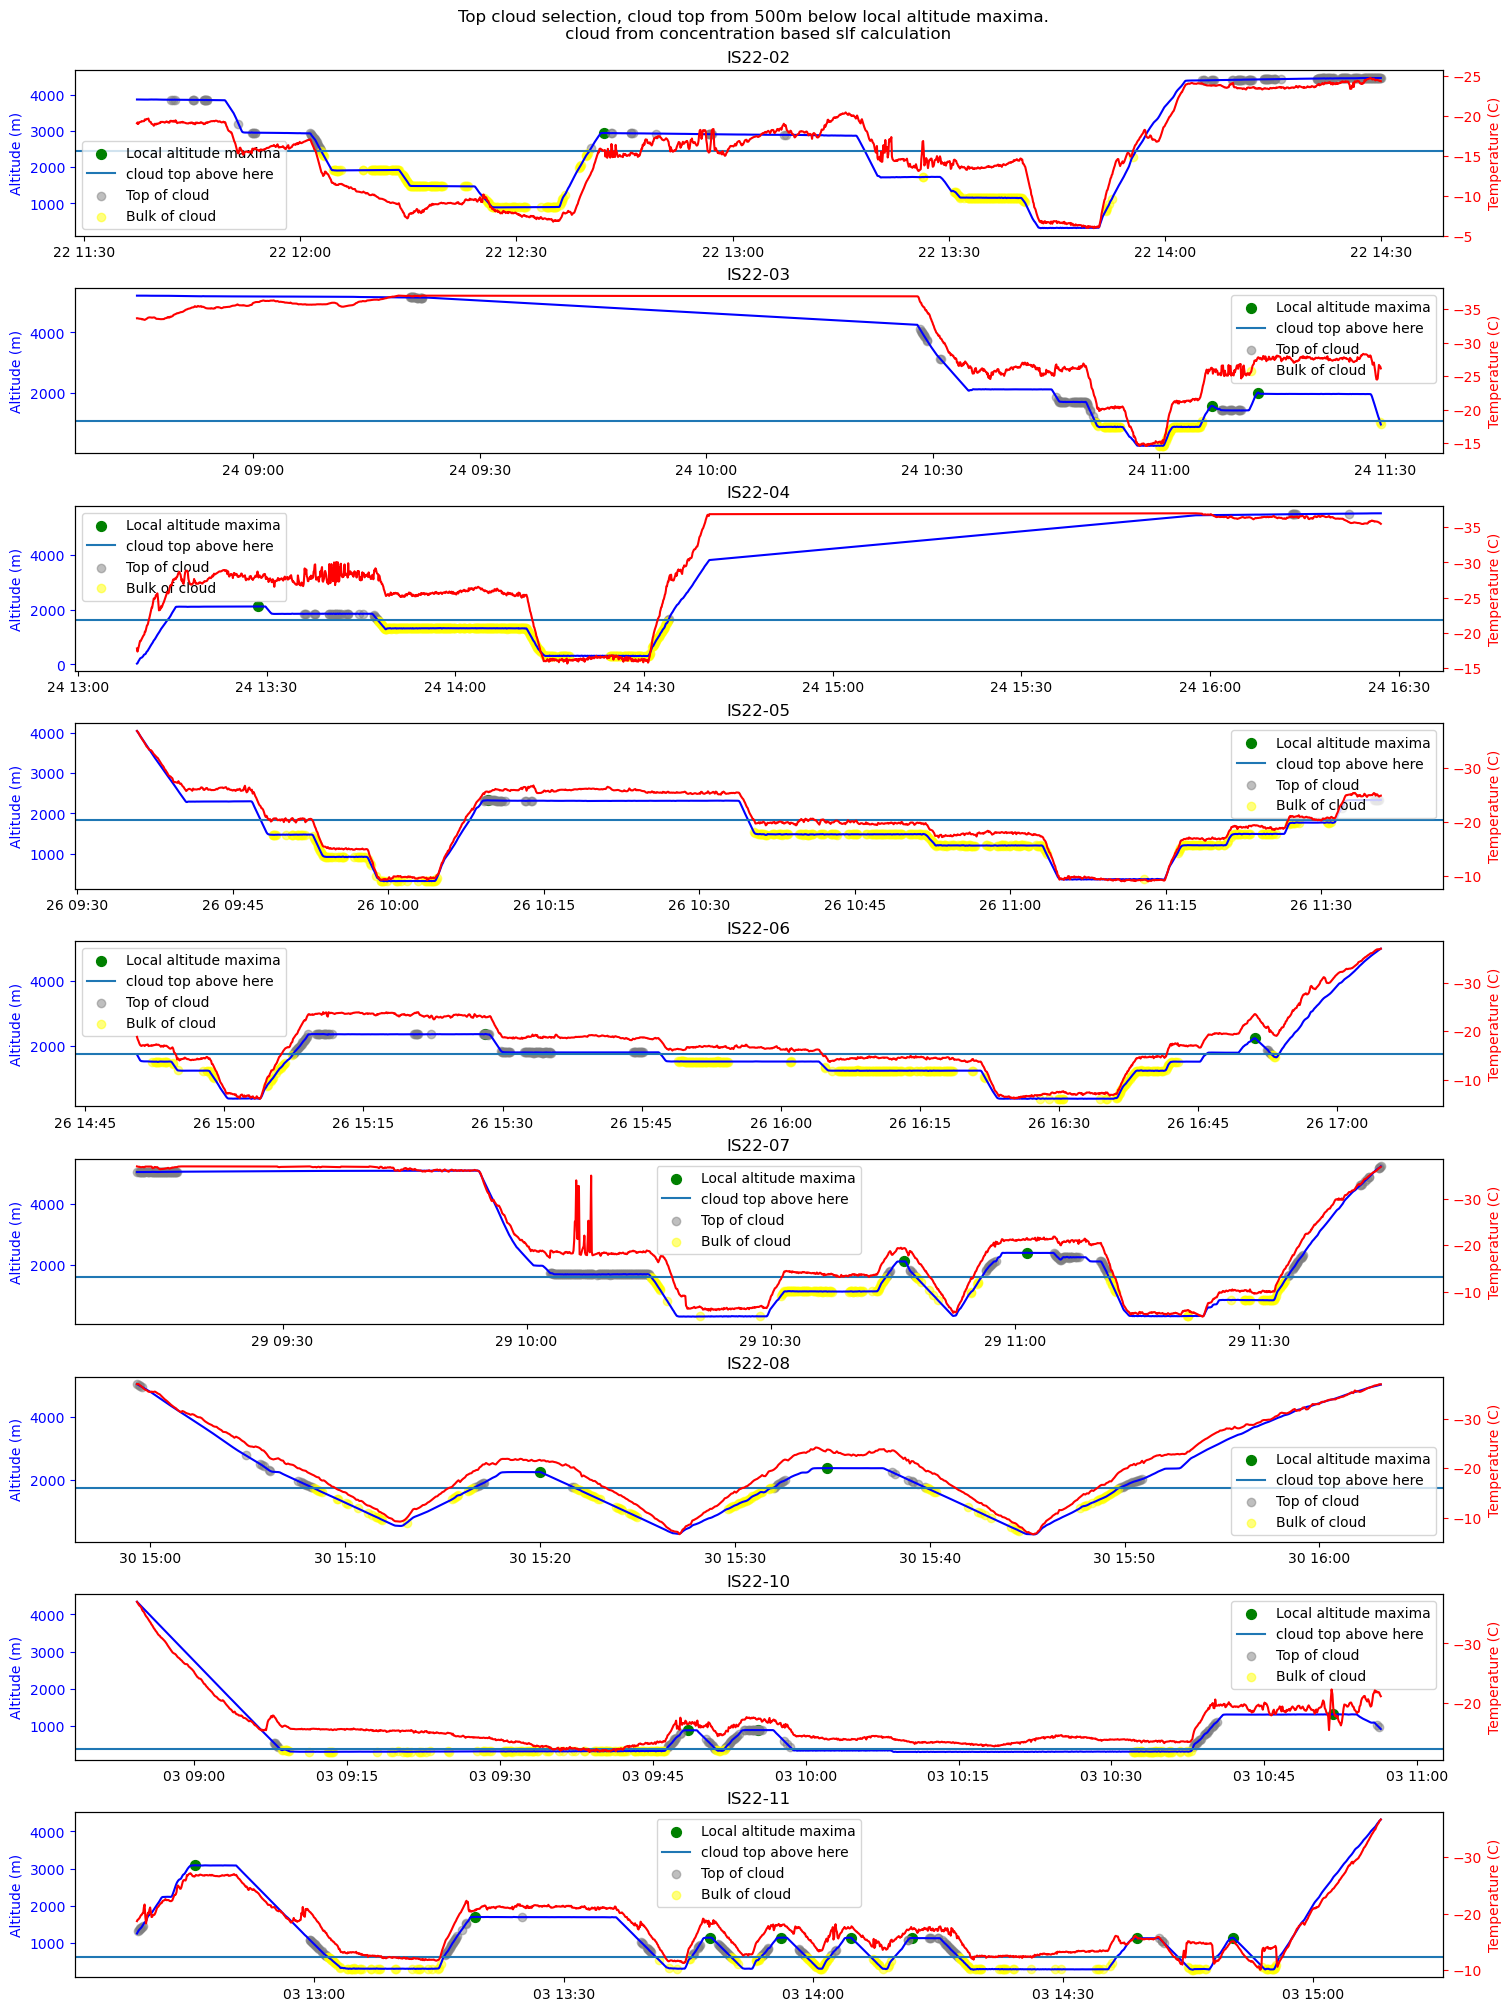

In [31]:
# get the dates from the dataset
islasid = np.unique(islas_ds['islasid'])
top_cloud_dict = {} # empty dictionary to store cloud top limit per flightid

diff = 500 # meters below local maxima to use as cloud top limit

fig, ax = plt.subplots(len(islasid),1, figsize = (15,20), layout='constrained')

for i, isid in enumerate(islasid):
    ds_all = islas_ds.where(islas_ds['islasid']==isid, drop=True)
    
    ax[i].set_title(isid)

    # plot altitude for the whole flight
    ax[i].plot(ds_all['time'], ds_all['alt'], c='b')
    ax[i].set_ylabel('Altitude (m)')
    ax[i].yaxis.label.set_color('b')
    ax[i].tick_params(axis='y', colors='b')

    # plot temperature for the flight
    ax_t = ax[i].twinx()
    ax_t.invert_yaxis()
    ax_t.set_ylabel('Temperature (C)')
    ax_t.yaxis.label.set_color('red')
    ax_t.tick_params(axis='y', colors='red')
    ax_t.plot(ds_all['time'], ds_all['T'], c='r')

    # Find and plot the local maxima
    x = ds_all['time'].values
    y = ds_all['alt'].values
    peak_loc, peak = find_peaks(y, height=500, prominence=150) #scipy function
    ax[i].scatter(x[peak_loc], peak['peak_heights'], c='g', s=50, label = 'Local altitude maxima')
    min_loc_max = np.min(peak['peak_heights'])
    cloud_top_limit = min_loc_max - diff # m below lowest maxima
    
    top_cloud_dict[isid] = cloud_top_limit # store cloud top limit in dicitonary for later use
    
    ax[i].axhline(y=cloud_top_limit, label = 'cloud top above here') # line defining the cloud top

    # defining out the top values from cloud top limit
    cloud_mask = (ds_all['cloud']==1).compute() # frist select out in cloud values (from concentration based slf)
    ds_cloud = ds_all.where(cloud_mask, drop =True)
    
    top_mask = (ds_cloud['alt']>cloud_top_limit).compute()
    bulk_mask = (ds_cloud['alt']<cloud_top_limit).compute()
    ds_top= ds_cloud.where(top_mask, drop=True)
    ds_bulk = ds_cloud.where(bulk_mask, drop =True)

    ax[i].scatter(ds_top['time'], ds_top['alt'], c='grey', alpha = 0.5, label = 'Top of cloud')
    ax[i].scatter(ds_bulk['time'], ds_bulk['alt'], c='yellow', alpha = 0.5, label = 'Bulk of cloud')
        
    ax[i].legend()

    plt.suptitle(f'Top cloud selection, cloud top from {diff}m below local altitude maxima. \n cloud from concentration based slf calculation')

plt.savefig(f'Cloud_top_selection.png')
plt.show()

In [10]:
# select out the Top x altitude bins
def sel_top(ds, top_dict):
    """Function filter the given ds on altitude per flightid
      Parameters
    ----------
    ds
        xarray dataset containing at least the variables 'alt' and 'islasid'
    top_dict
        dictionary consisting of the islas flight ids and an altitude threshold

    Returns
    -------
    top_ds
        Xarray dataset filtered on altitudes above the threshold given for each flightid

    """
    
    # set up "empty" mask
    top_mask = np.zeros(ds['alt'].shape, dtype = bool)

    # For each flight create a mask based on the threshold for each flightid
    for islasid, alt_thres in top_dict.items():
        id_mask = (ds['islasid'].values == islasid) & (ds['alt'].values > alt_thres) # mask from dictionary
        top_mask = top_mask | id_mask # Combine with overall mask

    # Convert the top_mask NumPy array into an xarray DataArray
    top_mask_da = xr.DataArray(top_mask, dims=ds['alt'].dims, coords=ds['alt'].coords)

    # Filter the ds on the full mask
    top_ds = ds.where(top_mask_da, drop=True)
    return top_ds

# get the top dataframes
top = 15
islas_top_ds = sel_top(islas_ds,top_cloud_dict)
islas_north_top_ds = sel_top(islas_north_ds,top_cloud_dict)
islas_south_top_ds = sel_top(islas_south_ds,top_cloud_dict)

# calculate slf (concentration_based)top altitude levels
slf_islas_t,tot_count_t = calc_slf(islas_top_ds)
slf_islas_t_n,tot_count_t_n = calc_slf(islas_north_top_ds)
slf_islas_t_s,tot_count_t_s = calc_slf(islas_south_top_ds)

In [11]:
# Calculating the mass-based slf
# use the same datapoints as for the concentration based by using the measurments set as 'cloud'
cloud_mask = (islas_ds['cloud']==1).compute()
islas_cloud_ds = islas_ds.where(cloud_mask, drop=True)

islas_cloud_ds['SLF_mass']=islas_cloud_ds['LWC corr']/(islas_cloud_ds['LWC corr']+islas_cloud_ds['IWC100'])
# get the norhtern and southern part of the islas_cloud_ds
islas_cloud_n_ds = islas_cloud_ds.where(islas_cloud_ds['lat']>lat_mid, drop=True)
islas_cloud_s_ds = islas_cloud_ds.where(islas_cloud_ds['lat']<lat_mid, drop=True)

# select out only top values (use same top as for the conc based
islas_cloud_top_ds = sel_top(islas_cloud_ds,top_cloud_dict)
islas_cloud_top_n_ds = sel_top(islas_cloud_n_ds,top_cloud_dict)
islas_cloud_top_s_ds = sel_top(islas_cloud_s_ds,top_cloud_dict)

# calculating the massbased for the plot, tot count is the same as for the concentration based
slf_islas_m = islas_cloud_ds['SLF_mass'].groupby('temp_bin').mean()
slf_islas_m_n = islas_cloud_n_ds['SLF_mass'].groupby('temp_bin').mean()
slf_islas_m_s = islas_cloud_s_ds['SLF_mass'].groupby('temp_bin').mean()
slf_islas_t_m = islas_cloud_top_ds['SLF_mass'].groupby('temp_bin').mean() # for top only
slf_islas_t_m_n = islas_cloud_top_n_ds['SLF_mass'].groupby('temp_bin').mean()
slf_islas_t_m_s = islas_cloud_top_s_ds['SLF_mass'].groupby('temp_bin').mean()


# get the tot count for the same
tot_count_m = islas_cloud_ds['cloud'].groupby('temp_bin').count()
tot_count_m_n = islas_cloud_n_ds['cloud'].groupby('temp_bin').count()
tot_count_m_s = islas_cloud_s_ds['cloud'].groupby('temp_bin').count()
tot_count_t_m = islas_cloud_top_ds['cloud'].groupby('temp_bin').count() # for top only
tot_count_t_m_n = islas_cloud_top_n_ds['cloud'].groupby('temp_bin').count()
tot_count_t_m_s = islas_cloud_top_s_ds['cloud'].groupby('temp_bin').count()


# get the "thresholds" from the ice and water parts
ice_mask = (islas_ds['ice']==1).compute()
islas_ice_ds = islas_ds.where(ice_mask, drop=True)
stats_IWC = pd.DataFrame(islas_ice_ds['IWC100']).describe()
min_IWC = islas_ice_ds['IWC100'].values.min()

liq_mask = (islas_ds['liq']==1).compute()
islas_liq_ds = islas_ds.where(liq_mask, drop=True)
stats_LWC = pd.DataFrame(islas_liq_ds['LWC corr']).describe()
min_LWC = islas_liq_ds['LWC corr'].values.min()

In [12]:
# islas mass based with korolev thresholds

# calculate SLF based on the values
islas_mass_ds['slf']=islas_mass_ds['LWC corr']/(islas_mass_ds['LWC corr']+islas_mass_ds['IWC100'])

# get the norhtern and southern part of the islas_cloud_ds
islas_mass_n_ds = islas_mass_ds.where(islas_mass_ds['lat']>lat_mid, drop=True)
islas_mass_s_ds = islas_mass_ds.where(islas_mass_ds['lat']<lat_mid, drop=True)

# select out only top values (use same top as for the conc based
islas_mass_top_ds = sel_top(islas_mass_ds,top_cloud_dict)
islas_mass_top_n_ds = sel_top(islas_mass_n_ds,top_cloud_dict)
islas_mass_top_s_ds = sel_top(islas_mass_s_ds,top_cloud_dict)

# group by the temperature bin
slf_islas_m2 = islas_mass_ds['slf'].groupby('temp_bin').mean()
slf_islas_m2_n = islas_mass_n_ds['slf'].groupby('temp_bin').mean()
slf_islas_m2_s = islas_mass_s_ds['slf'].groupby('temp_bin').mean()
slf_islas_t_m2 = islas_mass_top_ds['slf'].groupby('temp_bin').mean() # for top only
slf_islas_t_m2_n = islas_mass_top_n_ds['slf'].groupby('temp_bin').mean()
slf_islas_t_m2_s = islas_mass_top_s_ds['slf'].groupby('temp_bin').mean()

# get the tot count for the same
tot_count_m2 = islas_mass_ds['time'].groupby('temp_bin').count()
tot_count_m2_n = islas_mass_n_ds['time'].groupby('temp_bin').count()
tot_count_m2_s = islas_mass_s_ds['time'].groupby('temp_bin').count()
tot_count_t_m2 = islas_mass_top_ds['time'].groupby('temp_bin').count() # for top only
tot_count_t_m2_n = islas_mass_top_n_ds['time'].groupby('temp_bin').count()
tot_count_t_m2_s = islas_mass_top_s_ds['time'].groupby('temp_bin').count()

# how does the LWC vary
#plt.plot(islas_liq_ds['LWC corr'].values)

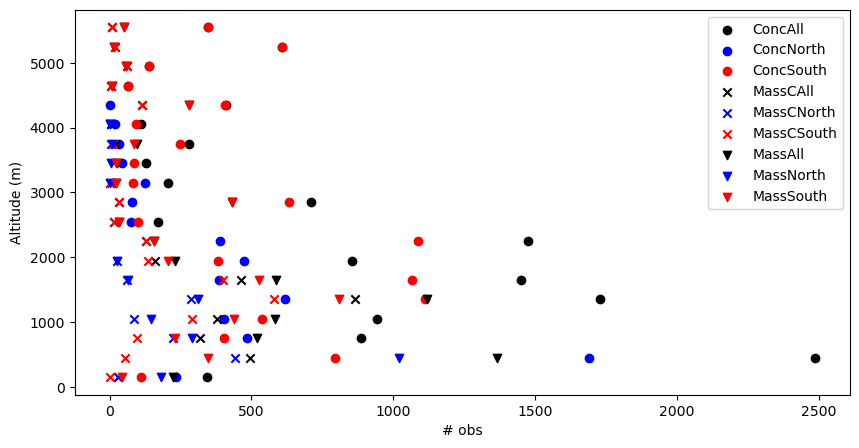

In [13]:
# overviews of altitude layers for the three ways of calculating the slf for the insitu data

# dss for concentration calculated
# islas_ds
y_call = np.unique(islas_ds['altitude_bin'].values)
x_call = islas_ds['time'].groupby('altitude_bin').count().values

# islas_north_ds
y_cn = np.unique(islas_north_ds['altitude_bin'].values)
x_cn = islas_north_ds['time'].groupby('altitude_bin').count().values

# islas_south_ds
y_cs = np.unique(islas_south_ds['altitude_bin'].values)
x_cs = islas_south_ds['time'].groupby('altitude_bin').count().values

# dss for massbased with conc ds
# islas_cloud_ds
y_mcall = np.unique(islas_cloud_ds['altitude_bin'].values)
x_mcall = islas_cloud_ds['time'].groupby('altitude_bin').count().values

# islas_cloud_n_ds
y_mcn = np.unique(islas_cloud_n_ds['altitude_bin'].values)
x_mcn = islas_cloud_n_ds['time'].groupby('altitude_bin').count().values

# islas_cloud_s_ds
y_mcs = np.unique(islas_cloud_s_ds['altitude_bin'].values)
x_mcs = islas_cloud_s_ds['time'].groupby('altitude_bin').count().values

# dss for massbased korolev th
# islas_mass_ds
y_mall = np.unique(islas_mass_ds['altitude_bin'].values)
x_mall = islas_mass_ds['time'].groupby('altitude_bin').count().values

# islas_mass_n_ds
y_mn = np.unique(islas_mass_n_ds['altitude_bin'].values)
x_mn = islas_mass_n_ds['time'].groupby('altitude_bin').count().values

# islas_mass_s_ds
y_ms = np.unique(islas_mass_s_ds['altitude_bin'].values)
x_ms = islas_mass_s_ds['time'].groupby('altitude_bin').count().values


fig,ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(x_call,y_call, c='k',  label='ConcAll')
ax.scatter(x_cn,y_cn, c='b', label='ConcNorth')
ax.scatter(x_cs,y_cs, c='r', label='ConcSouth')

ax.scatter(x_mcall,y_mcall, c='k', marker='x', label='MassCAll')
ax.scatter(x_mcn,y_mcn, c='b',marker='x', label='MassCNorth')
ax.scatter(x_mcs,y_mcs, c='r', marker='x',label='MassCSouth')

ax.scatter(x_mall,y_mall, c='k', marker='v', label='MassAll')
ax.scatter(x_mn,y_mn, c='b',marker='v', label='MassNorth')
ax.scatter(x_ms,y_ms, c='r', marker='v',label='MassSouth')

ax.set_ylabel('Altitude (m)')
ax.set_xlabel('# obs')
plt.legend()
plt.show()

## CALIPSO preparation

In [14]:
# prepare data (all years, bulk)

# JFMA
JFMA_whole_ds = create_ds_with_attrs(jfma_files[0], cal_path)
JFMA_north_ds = create_ds_with_attrs(jfma_files[1], cal_path)
JFMA_south_ds = create_ds_with_attrs(jfma_files[2], cal_path)

# FM
FM_whole_ds = create_ds_with_attrs(fm_files[0], cal_path)
FM_north_ds = create_ds_with_attrs(fm_files[1], cal_path)
FM_south_ds = create_ds_with_attrs(fm_files[2], cal_path)

# DJFMA
DJFMA_whole_ds = create_ds_with_attrs(djfma_files[0], cal_path)
DJFMA_north_ds = create_ds_with_attrs(djfma_files[2], cal_path)
DJFMA_south_ds = create_ds_with_attrs(djfma_files[2], cal_path)


In [15]:
DJFMA_north_ds

<xarray.Dataset> Size: 7kB
Dimensions:      (year: 15, temperature: 28)
Coordinates:
  * year         (year) int64 120B 2009 2010 2011 2012 ... 2020 2021 2022 2023
  * temperature  (temperature) float64 224B 224.0 226.0 228.0 ... 276.0 278.0
Data variables:
    count        (year, temperature) int64 3kB ...
    slf          (year, temperature) int64 3kB ...
Attributes:
    filename:  SLF_2009_2023_DJFMA_south.nc
    cloudtop:  False
    months:    DJFMA
    region:    south

### Temperature
The temperature variable in the files are given in Kelvin. To get Celsius subtract 272. 
The temperature is in the range -48 to + 6C and are in 2 degree increments. (a total of 28 'bins')

### Year
The year variable in the files are either 2022 (one year) or the years 2009-2023 (15 years)

### Count

The count variable has two dimentions: year and temperature. one array per year where each value is the count per temperature bin. 

In [16]:
count = JFMA_whole_ds['count'].values
#count[0]

### SLF
The slf variable has two dimentions: year and temperature. Year is the 'row' and temperature is the 'column' (array per year)
The value within each is the supercooled liquid count for that temperature and year.

In [17]:
slf = JFMA_whole_ds['slf'].values
#slf[0]

In [18]:
JFMA_north_ds.attrs['cloudtop']

False

In [19]:
# testing buildinga small dataclass for storing information
from dataclasses import dataclass

@dataclass
class Plottype:
    region: str
    text: str
    col1: str
    col2: str

regions = [Plottype("whole","Both regions","k","lightgrey"),
           Plottype("north","Northern region","b","lightblue"),
           Plottype("south","Southern region","r","pink")]

def get_plot_info(region_name):
    for region in regions:
        if region.region == region_name:
            return region
    return None  # or raise an error if you prefer


test = get_plot_info(JFMA_north_ds.attrs['region'])
print(test.text)

Northern region


In [20]:
from matplotlib.gridspec import GridSpec # gridspec for nested subfigures

/tmp/ipykernel_30473/2527557669.py:144: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(f'calipso_islas_sl_top_{months}{titex}_sr{sample_rate}s_th{th_ice}.png')
/home/ninalar/miniconda3/envs/microphy/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


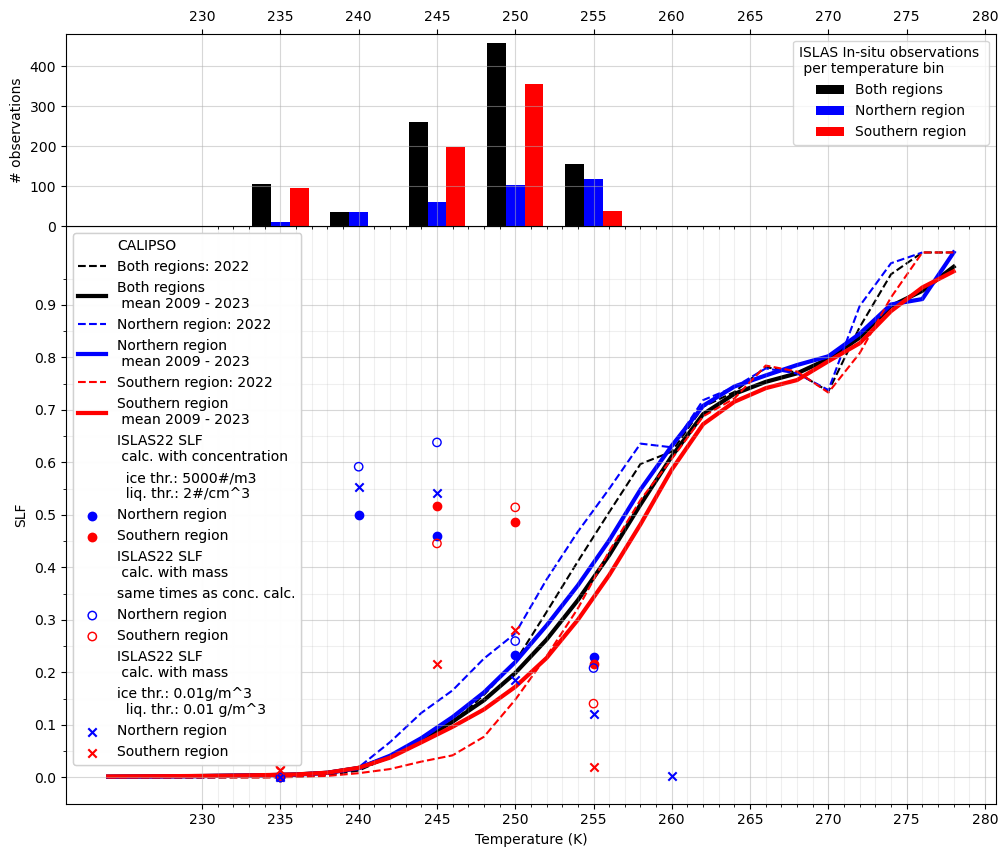

In [32]:
# JFMA with top layer islas

JFMA_whole_ds = create_ds_with_attrs(jfma_files[0], cal_path)
JFMA_north_ds = create_ds_with_attrs(jfma_files[1], cal_path)
JFMA_south_ds = create_ds_with_attrs(jfma_files[2], cal_path)

months = JFMA_north_ds.attrs['months']

# --- Set up figure
fig = plt.figure(figsize=(15, 10), layout = 'constrained')

if JFMA_north_ds.attrs['cloudtop']:
    titex = ' - Top'
else:
    titex = ''

gs = GridSpec(4,5, wspace=0,hspace=0)
ax_main = plt.subplot(gs[1:5,0:4])
ax_insitu = plt.subplot(gs[0,0:4], sharex=ax_main)

#ax_main.set_title(f'CALIPSO SLF {months}{titex} (ISLAS:{sample_rate}s)')

ax_main.add_line(Line2D([],[],color = "none", label = 'CALIPSO')) # calipso title for legend
for ds in [JFMA_whole_ds,JFMA_north_ds,JFMA_south_ds]:
    # drop temperatures outside of -35 to 0
    #ds = ds.where(temp_mask, drop=True)
    # calculate slf percent
    ds['slf_perc'] = ds['slf']/ds ['count']
    
    # get information for plots from attributes
    plot_info = get_plot_info(ds.attrs['region'])
    # plot for whole dataset (black)
    for year in ds['year']:
        if year == 2022:
            l = f'{plot_info.text}: 2022'
            col = plot_info.col1
            line='--'
            ax_main.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line,
                    label=l, zorder = 1)
        #elif year == np.min(ds['year']).values:
         #   l = f'{plot_info.text}: {np.min(ds['year']).values} - {np.max(ds['year']).values}'
         #   col = plot_info.col2
         #   line='-'
        #else:
         #   l='_nolegend_'
         #   col = plot_info.col2
         #   line='-'
       # ax_main.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line, label=l)
    
    # Plot the mean of all the years
    mean_ds = ds['slf_perc'].mean(dim='year')
    ax_main.plot(mean_ds['temperature'],mean_ds, label = f'{plot_info.text} \n mean {np.min(ds['year']).values} - {np.max(ds['year']).values}',
            c=plot_info.col1, lw=3, zorder = 1)

# plot the insitu slf values as dots
# concentration based
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF \n calc. with concentration')) # Islas title for legend
ax_main.add_line(Line2D([],[],color = "none", label = f'  ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n  liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}')) # title for legend
#ax_main.scatter(slf_islas['temp_bin'], slf_islas, label = f'ISLAS22 concSLF both regions', c='k', zorder = 2)
ax_main.scatter(slf_islas_t_n['temp_bin'], slf_islas_t_n, label = f'Northern region', c='b', zorder = 2)
ax_main.scatter(slf_islas_t_s['temp_bin'], slf_islas_t_s, label = f'Southern region', c='r', zorder = 2)

# mass based, dataset from concentration
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF \n calc. with mass')) # Islas title for legend
ax_main.add_line(Line2D([],[],color = "none", label = 'same times as conc. calc.')) # title for legend
#ax_main.scatter(slf_islas_m['temp_bin'], slf_islas_m, label = f'ISLAS22 massSLF both regions', edgecolors='k', facecolors='none', alpha = 1, 
 #          marker = 'o', zorder = 3)
ax_main.scatter(slf_islas_t_m_n['temp_bin'], slf_islas_t_m_n, label = f'Northern region', edgecolors='b', facecolors='none',alpha = 1,
           marker = 'o', zorder = 3)
ax_main.scatter(slf_islas_t_m_s['temp_bin'], slf_islas_t_m_s, label = f'Southern region', edgecolors='r', facecolors='none',alpha = 1, 
           marker = 'o', zorder = 3)

# mass based, korolev threshold
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF \n calc. with mass')) # Islas title for legend
ax_main.add_line(Line2D([],[],color = "none", label = f'ice thr.: {lwc_th}g/m^3 \n  liq. thr.: {lwc_th} g/m^3')) # title for legend
#ax_main.scatter(slf_islas_m2['temp_bin'], slf_islas_m2, label = f'ISLAS22 massSLF_2 both regions', edgecolors='k', facecolors='none', alpha = 1, 
 #          marker = 'x', zorder = 3)
ax_main.scatter(slf_islas_t_m2_n['temp_bin'], slf_islas_t_m2_n, label = f'Northern region', c='b',alpha = 1,
           marker = 'x', zorder = 3)
ax_main.scatter(slf_islas_t_m2_s['temp_bin'], slf_islas_t_m2_s, label = f'Southern region', c='r',alpha = 1, 
           marker = 'x', zorder = 3)

ax_main.set_ylabel(f'SLF')
ax_main.set_xlabel(f'Temperature (K)')

# legend
main_legend = ax_main.legend(loc='upper left', frameon = True) # general legend
# Second Legend for concentration-based scatterplots
#custom_legend_elements = [
 #   Line2D([0], [0], marker='o', color='w', label=f'concSLF: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markerfacecolor='k', markersize=10),
  #  Line2D([0], [0], marker='X', color='w', label=f'massSLF: \n lowest IWC: {min_IWC:.5f}{islas_ds.IWC100.attrs['units']} \n lowest LWC: {min_LWC:.5f}{islas_ds['LWC corr'].attrs['unit']}', markerfacecolor='k', markersize=10) #,
   # Line2D([0], [0], marker='o', color='w', label=f'massSLF th. set: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markerfacecolor='k', markersize=10)
#]

# Add second legend to the plot at a specific location
#ax_main.legend(handles=custom_legend_elements, loc='lower right', frameon=True, title='Thresholds')

ax_main.add_artist(main_legend)

ax_main.grid(True) 
# Gridline adjustments
major_ticks_y = np.arange(0, 1, 0.1) 
minor_ticks_y = np.arange(0, 1, 0.05)

major_ticks_x = np.arange(230, 281, 5)
minor_ticks_x = np.arange(230, 281, 1)

ax_main.set_xticks(major_ticks_x)
ax_main.set_xticks(minor_ticks_x, minor=True)
ax_main.set_yticks(major_ticks_y)
ax_main.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax_main.grid(which='both')

# Or if you want different settings for the grids:
ax_main.grid(which='minor', alpha=0.2)
ax_main.grid(which='major', alpha=0.5)
#-------

#ax_main.set_xlim(230, 270)

# plot of number of observations per temperature bin
ax_insitu.set_ylabel('# observations')
#ax_insitu.set_xlabel(f'Temperature (K)')
ax_insitu.tick_params(top=True, labeltop=True, bottom = False, labelbottom = False)
# concentration based
bwidth=1.2
ax_insitu.bar(slf_islas_t['temp_bin']-bwidth, tot_count_t.values, width=bwidth,facecolor='k', label='Both regions')
ax_insitu.bar(slf_islas_t_n['temp_bin'], tot_count_t_n.values,width=bwidth, facecolor='b',label ='Northern region')
ax_insitu.bar(slf_islas_t_s['temp_bin']+bwidth, tot_count_t_s.values,width=bwidth, facecolor='r',label ='Southern region')
ax_insitu.legend(title = 'ISLAS In-situ observations \n per temperature bin')
# mass based THE same as the other one!!
#ax_insitu.plot(slf_islas_m['temp_bin'], tot_count_m.values, c='k')
#ax_insitu.plot(slf_islas_m_n['temp_bin'], tot_count_m_n.values, c='b')
#ax_insitu.plot(slf_islas_m_s['temp_bin'], tot_count_m_s.values, c='r')

ax_insitu.grid(which='major')

# Or if you want different settings for the grids:
#ax_insitu.grid(which='minor', alpha=0.2)
ax_insitu.grid(which='major', alpha=0.5)

plt.savefig(f'calipso_islas_sl_top_{months}{titex}_sr{sample_rate}s_th{th_ice}.png')

plt.show()

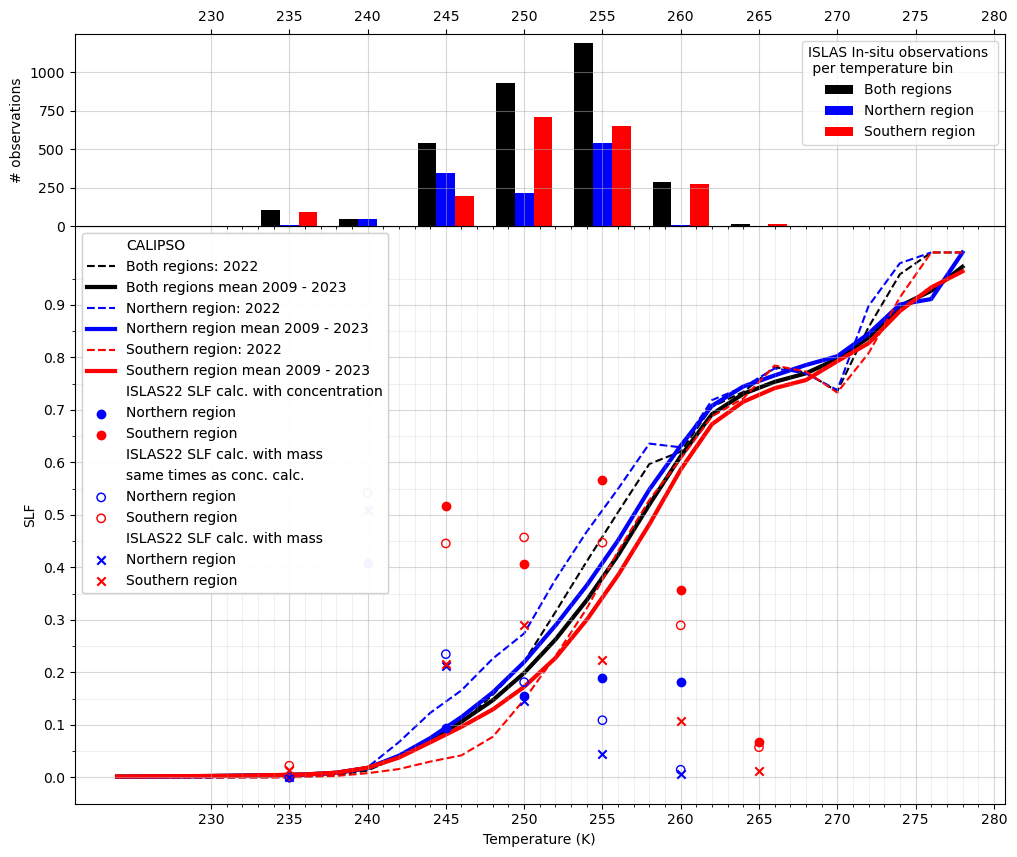

In [23]:
# JFMA with updates

JFMA_whole_ds = create_ds_with_attrs(jfma_files[0], cal_path)
JFMA_north_ds = create_ds_with_attrs(jfma_files[1], cal_path)
JFMA_south_ds = create_ds_with_attrs(jfma_files[2], cal_path)

months = JFMA_north_ds.attrs['months']

# --- Set up figure
fig = plt.figure(figsize=(15, 10))

if JFMA_north_ds.attrs['cloudtop']:
    titex = ' - Top'
else:
    titex = ''

gs = GridSpec(4,5, wspace=0,hspace=0)
ax_main = plt.subplot(gs[1:5,0:4])
ax_insitu = plt.subplot(gs[0,0:4], sharex=ax_main)

#ax_main.set_title(f'CALIPSO SLF {months}{titex} (ISLAS:{sample_rate}s)')

ax_main.add_line(Line2D([],[],color = "none", label = 'CALIPSO')) # calipso title for legend
for ds in [JFMA_whole_ds,JFMA_north_ds,JFMA_south_ds]:
    # drop temperatures outside of -35 to 0
    #ds = ds.where(temp_mask, drop=True)
    # calculate slf percent
    ds['slf_perc'] = ds['slf']/ds ['count']
    
    # get information for plots from attributes
    plot_info = get_plot_info(ds.attrs['region'])
    # plot for whole dataset (black)
    for year in ds['year']:
        if year == 2022:
            l = f'{plot_info.text}: 2022'
            col = plot_info.col1
            line='--'
            ax_main.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line,
                    label=l, zorder = 1)
        #elif year == np.min(ds['year']).values:
         #   l = f'{plot_info.text}: {np.min(ds['year']).values} - {np.max(ds['year']).values}'
         #   col = plot_info.col2
         #   line='-'
        #else:
         #   l='_nolegend_'
         #   col = plot_info.col2
         #   line='-'
       # ax_main.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line, label=l)
    
    # Plot the mean of all the years
    mean_ds = ds['slf_perc'].mean(dim='year')
    ax_main.plot(mean_ds['temperature'],mean_ds, label = f'{plot_info.text} mean {np.min(ds['year']).values} - {np.max(ds['year']).values}',
            c=plot_info.col1, lw=3, zorder = 1)

# plot the insitu slf values as dots
# concentration based
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF calc. with concentration')) # Islas title for legend
#ax_main.add_line(Line2D([],[],color = "none", label = f'  ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n  liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}')) # title for legend
#ax_main.scatter(slf_islas['temp_bin'], slf_islas, label = f'ISLAS22 concSLF both regions', c='k', zorder = 2)
ax_main.scatter(slf_islas_n['temp_bin'], slf_islas_n, label = f'Northern region', c='b', zorder = 2)
ax_main.scatter(slf_islas_s['temp_bin'], slf_islas_s, label = f'Southern region', c='r', zorder = 2)

# mass based, dataset from concentration
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF calc. with mass')) # Islas title for legend
ax_main.add_line(Line2D([],[],color = "none", label = 'same times as conc. calc.')) # title for legend
#ax_main.scatter(slf_islas_m['temp_bin'], slf_islas_m, label = f'ISLAS22 massSLF both regions', edgecolors='k', facecolors='none', alpha = 1, 
 #          marker = 'o', zorder = 3)
ax_main.scatter(slf_islas_m_n['temp_bin'], slf_islas_m_n, label = f'Northern region', edgecolors='b', facecolors='none',alpha = 1,
           marker = 'o', zorder = 3)
ax_main.scatter(slf_islas_m_s['temp_bin'], slf_islas_m_s, label = f'Southern region', edgecolors='r', facecolors='none',alpha = 1, 
           marker = 'o', zorder = 3)

# mass based, korolev threshold
ax_main.add_line(Line2D([],[],color = "none", label = 'ISLAS22 SLF calc. with mass')) # Islas title for legend
#ax_main.add_line(Line2D([],[],color = "none", label = 'ice thr.: {lwc_th} g/m^3 \n  liq. thr.: {lwc_th} g/m^3')) # title for legend
#ax_main.scatter(slf_islas_m2['temp_bin'], slf_islas_m2, label = f'ISLAS22 massSLF_2 both regions', edgecolors='k', facecolors='none', alpha = 1, 
 #          marker = 'x', zorder = 3)
ax_main.scatter(slf_islas_m2_n['temp_bin'], slf_islas_m2_n, label = f'Northern region', c='b',alpha = 1,
           marker = 'x', zorder = 3)
ax_main.scatter(slf_islas_m2_s['temp_bin'], slf_islas_m2_s, label = f'Southern region', c='r',alpha = 1, 
           marker = 'x', zorder = 3)

ax_main.set_ylabel(f'SLF')
ax_main.set_xlabel(f'Temperature (K)')

# legend
main_legend = ax_main.legend(loc='upper left', frameon = True) # general legend
# Second Legend for concentration-based scatterplots
#custom_legend_elements = [
 #   Line2D([0], [0], marker='o', color='w', label=f'concSLF: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markerfacecolor='k', markersize=10),
  #  Line2D([0], [0], marker='X', color='w', label=f'massSLF: \n lowest IWC: {min_IWC:.5f}{islas_ds.IWC100.attrs['units']} \n lowest LWC: {min_LWC:.5f}{islas_ds['LWC corr'].attrs['unit']}', markerfacecolor='k', markersize=10) #,
   # Line2D([0], [0], marker='o', color='w', label=f'massSLF th. set: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markerfacecolor='k', markersize=10)
#]

# Add second legend to the plot at a specific location
#ax_main.legend(handles=custom_legend_elements, loc='lower right', frameon=True, title='Thresholds')

ax_main.add_artist(main_legend)

ax_main.grid(True) 
# Gridline adjustments
major_ticks_y = np.arange(0, 1, 0.1) 
minor_ticks_y = np.arange(0, 1, 0.05)

major_ticks_x = np.arange(230, 281, 5)
minor_ticks_x = np.arange(230, 281, 1)

ax_main.set_xticks(major_ticks_x)
ax_main.set_xticks(minor_ticks_x, minor=True)
ax_main.set_yticks(major_ticks_y)
ax_main.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax_main.grid(which='both')

# Or if you want different settings for the grids:
ax_main.grid(which='minor', alpha=0.2)
ax_main.grid(which='major', alpha=0.5)
#-------

#ax_main.set_xlim(230, 270)

# plot of number of observations per temperature bin
ax_insitu.set_ylabel('# observations')
#ax_insitu.set_xlabel(f'Temperature (K)')
ax_insitu.tick_params(top=True, labeltop=True, bottom = False, labelbottom = False)
# concentration based
bwidth=1.2
ax_insitu.bar(slf_islas['temp_bin']-bwidth, tot_count.values, width=bwidth,facecolor='k', label='Both regions')
ax_insitu.bar(slf_islas_n['temp_bin'], tot_count_n.values,width=bwidth, facecolor='b',label ='Northern region')
ax_insitu.bar(slf_islas_s['temp_bin']+bwidth, tot_count_s.values,width=bwidth, facecolor='r',label ='Southern region')
ax_insitu.legend(title = 'ISLAS In-situ observations \n per temperature bin')
# mass based THE same as the other one!!
#ax_insitu.plot(slf_islas_m['temp_bin'], tot_count_m.values, c='k')
#ax_insitu.plot(slf_islas_m_n['temp_bin'], tot_count_m_n.values, c='b')
#ax_insitu.plot(slf_islas_m_s['temp_bin'], tot_count_m_s.values, c='r')

ax_insitu.grid(which='major')

# Or if you want different settings for the grids:
#ax_insitu.grid(which='minor', alpha=0.2)
ax_insitu.grid(which='major', alpha=0.5)

#plt.savefig(f'calipso_islas_slf_{months}{titex}_sr{sample_rate}s_th{th_ice}.png')

plt.show()

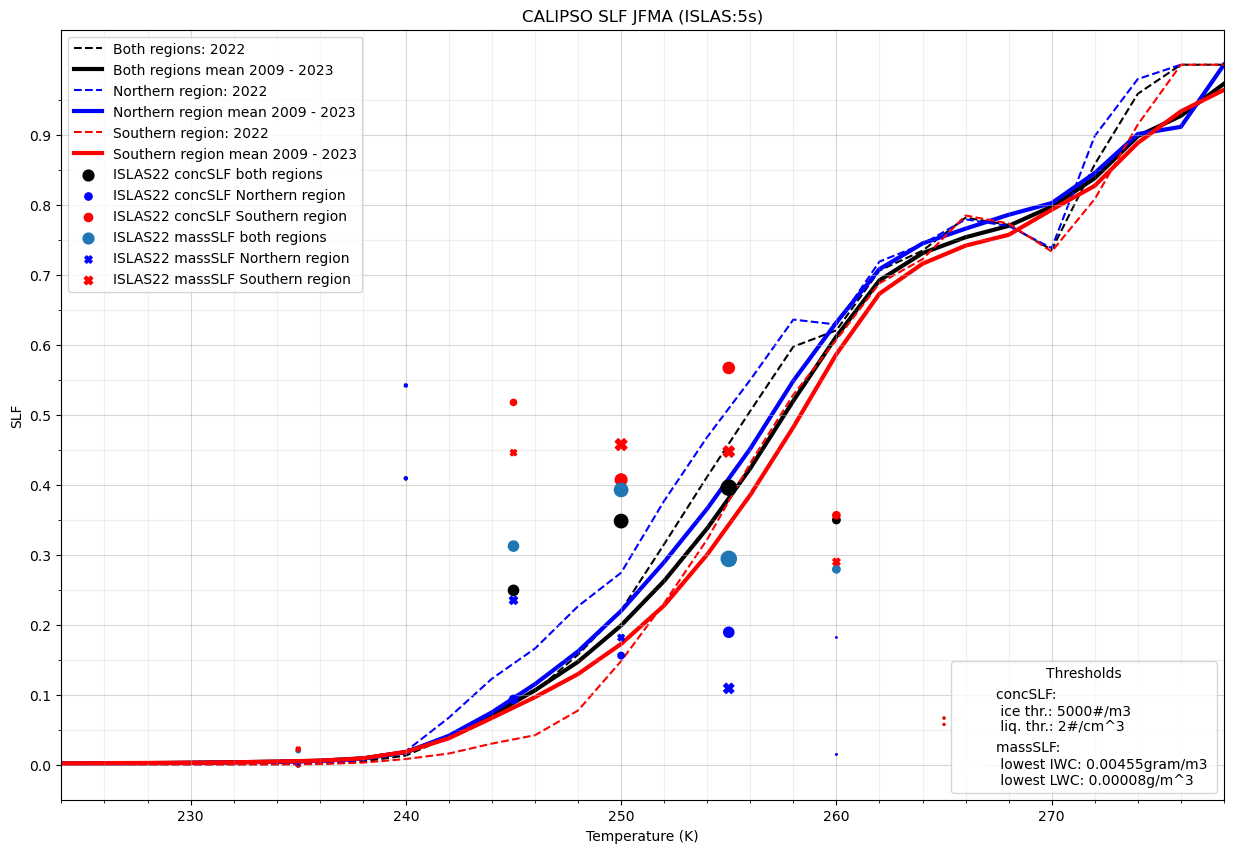

In [163]:
# JFMA - First attempt

JFMA_whole_ds = create_ds_with_attrs(jfma_files[0], cal_path)
JFMA_north_ds = create_ds_with_attrs(jfma_files[1], cal_path)
JFMA_south_ds = create_ds_with_attrs(jfma_files[2], cal_path)

months = JFMA_north_ds.attrs['months']

# --- Set up figure
fig, ax = plt.subplots(1,1,figsize=(15, 10))

if JFMA_north_ds.attrs['cloudtop']:
    titex = ' - Top'
else:
    titex = ''

ax.set_title(f'CALIPSO SLF {months}{titex} (ISLAS:{sample_rate}s)')


for ds in [JFMA_whole_ds,JFMA_north_ds,JFMA_south_ds]:
    # drop temperatures outside of -35 to 0
    #ds = ds.where(temp_mask, drop=True)
    # calculate slf percent
    ds['slf_perc'] = ds['slf']/ds ['count']
    
    # get information for plots from attributes
    plot_info = get_plot_info(ds.attrs['region'])
    # plot for whole dataset (black)
    for year in ds['year']:
        if year == 2022:
            l = f'{plot_info.text}: 2022'
            col = plot_info.col1
            line='--'
            ax.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line,
                    label=l, zorder = 1)
        #elif year == np.min(ds['year']).values:
         #   l = f'{plot_info.text}: {np.min(ds['year']).values} - {np.max(ds['year']).values}'
         #   col = plot_info.col2
         #   line='-'
        #else:
         #   l='_nolegend_'
         #   col = plot_info.col2
         #   line='-'
       # ax.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line, label=l)
    
    # Plot the mean of all the years
    mean_ds = ds['slf_perc'].mean(dim='year')
    ax.plot(mean_ds['temperature'],mean_ds, label = f'{plot_info.text} mean {np.min(ds['year']).values} - {np.max(ds['year']).values}',
            c=plot_info.col1, lw=3, zorder = 1)

# plot the insitu slf values as dots
# concentration based
ax.scatter(slf_islas['temp_bin'], slf_islas, label = f'ISLAS22 concSLF both regions', c='k', s=tot_count.values/10, zorder = 2)
ax.scatter(slf_islas_n['temp_bin'], slf_islas_n, label = f'ISLAS22 concSLF Northern region', c='b', s=tot_count_n.values/10, zorder = 2)
ax.scatter(slf_islas_s['temp_bin'], slf_islas_s, label = f'ISLAS22 concSLF Southern region', c='r', s=tot_count_s.values/10, zorder = 2)

# mass based
ax.scatter(slf_islas_m['temp_bin'], slf_islas_m, label = f'ISLAS22 massSLF both regions', alpha = 1, 
           marker = 'o', s=tot_count_m.values/10, zorder = 3)
ax.scatter(slf_islas_m_n['temp_bin'], slf_islas_m_n, label = f'ISLAS22 massSLF Northern region', c='b', alpha = 1,
           marker = 'X', s=tot_count_m_n.values/10, zorder = 3)
ax.scatter(slf_islas_m_s['temp_bin'], slf_islas_m_s, label = f'ISLAS22 massSLF Southern region', c='r', alpha = 1, 
           marker = 'X', s=tot_count_m_s.values/10, zorder = 3)

ax.set_ylabel(f'SLF')
ax.set_xlabel(f'Temperature (K)')

# legend
main_legend = ax.legend(loc='upper left', frameon = True) # general legend
# Second Legend for concentration-based scatterplots
custom_legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f'concSLF: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markersize=10),
    Line2D([0], [0], marker='X', color='w', label=f'massSLF: \n lowest IWC: {min_IWC:.5f}{islas_ds.IWC100.attrs['units']} \n lowest LWC: {min_LWC:.5f}{islas_ds['LWC corr'].attrs['unit']}', markersize=10) #,
   # Line2D([0], [0], marker='o', color='w', label=f'massSLF th. set: \n ice thr.: {th_ice}{islas_ds.NT100.attrs['units']} \n liq. thr.: {th_liq}{islas_ds['Number Conc corr'].attrs['unit']}', markersize=10)
]

# Add second legend to the plot at a specific location
ax.legend(handles=custom_legend_elements, loc='lower right', frameon=True, title='Thresholds')

plt.gca().add_artist(main_legend)

ax.grid(True) 
# Gridline adjustments
major_ticks_y = np.arange(0, 1, 0.1) 
minor_ticks_y = np.arange(0, 1, 0.05)

major_ticks_x = np.arange(220, 281, 10)
minor_ticks_x = np.arange(220, 281, 2)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
#-------

ax.set_xlim(ds['temperature'].min(), ds['temperature'].max())

plt.savefig(f'calipso_islas_slf_{months}{titex}_sr{sample_rate}s_th{th_ice}.png')

plt.show()

## Unused plots

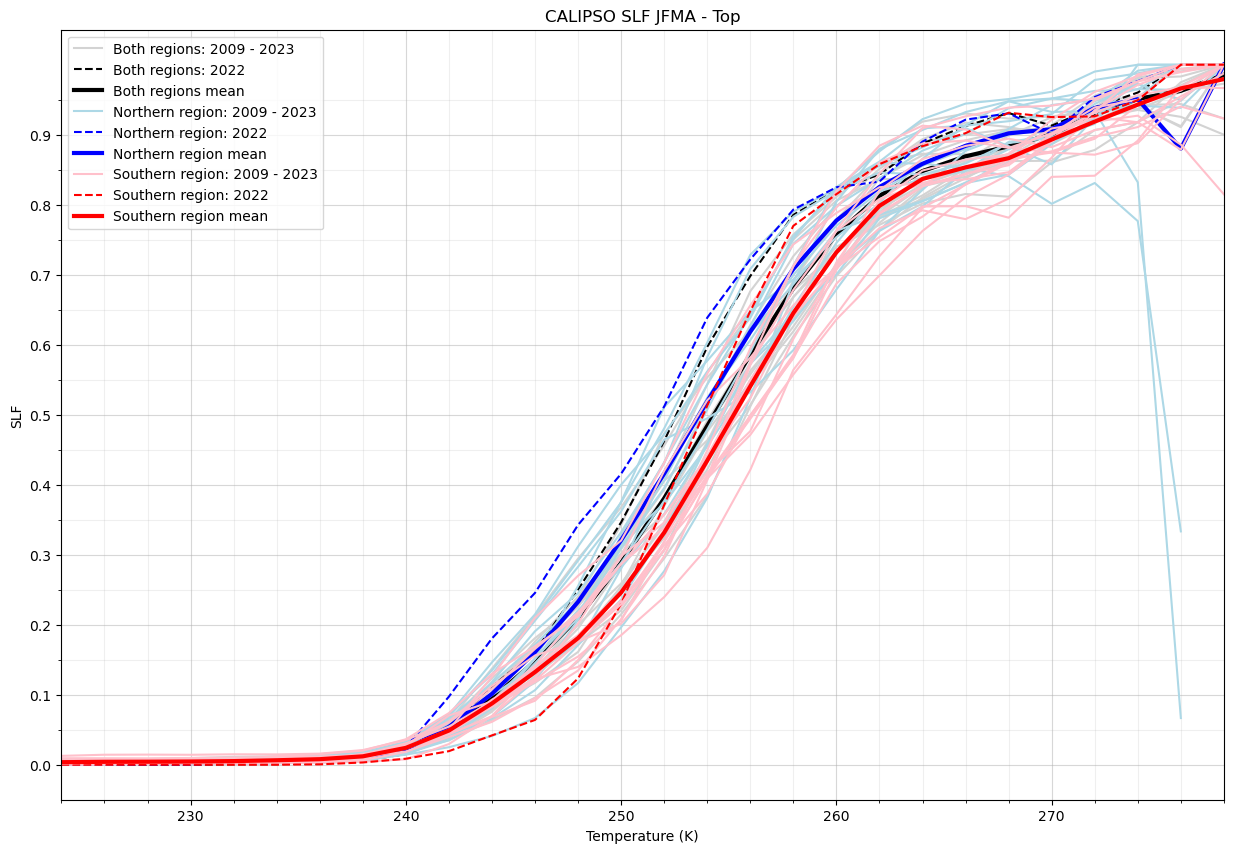

In [164]:
# JFMA Top

JFMAt_whole_ds = create_ds_with_attrs(jfma_files[3], cal_path)
JFMAt_north_ds = create_ds_with_attrs(jfma_files[4], cal_path)
JFMAt_south_ds = create_ds_with_attrs(jfma_files[5], cal_path)

months = JFMAt_north_ds.attrs['months']

# --- Set up figure
fig, ax = plt.subplots(1,1,figsize=(15, 10))

if JFMAt_north_ds.attrs['cloudtop']:
    titex = ' - Top'
else:
    titex = ''

ax.set_title(f'CALIPSO SLF {months}{titex}')

for ds in [JFMAt_whole_ds,JFMAt_north_ds,JFMAt_south_ds]:
    # calculate slf percent
    ds['slf_perc'] = ds['slf']/ds ['count']
    
    # get information for plots from attributes
    plot_info = get_plot_info(ds.attrs['region'])
    # plot for whole dataset (black)
    for year in ds['year']:
        if year == 2022:
            l = f'{plot_info.text}: 2022'
            col = plot_info.col1
            line='--'
        elif year == np.min(ds['year']).values:
            l = f'{plot_info.text}: {np.min(ds['year']).values} - {np.max(ds['year']).values}'
            col = plot_info.col2
            line='-'
        else:
            l='_nolegend_'
            col = plot_info.col2
            line='-'
        ax.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line, label=l)
    
    # Plot the mean of all the years
    mean_ds = ds['slf_perc'].mean(dim='year')
    ax.plot(mean_ds['temperature'],mean_ds, label = f'{plot_info.text} mean', c=plot_info.col1, lw=3)


ax.set_ylabel(f'SLF')
ax.set_xlabel(f'Temperature (K)')
ax.legend()

ax.grid(True) 
# Gridline adjustments
major_ticks_y = np.arange(0, 1, 0.1) 
minor_ticks_y = np.arange(0, 1, 0.05)

major_ticks_x = np.arange(220, 281, 10)
minor_ticks_x = np.arange(220, 281, 2)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
#-------
ax.set_xlim(ds['temperature'].min(), ds['temperature'].max())
plt.savefig(f'calipso_slf_{months}{titex}.png')
plt.show()

In [165]:
islas_top_ds['cloud'].values

array([0., 0., 0., ..., 0., 0., 0.], shape=(8675,))

<xarray.DataArray 'count' (year: 15)> Size: 120B
array([10285.60714286, 15564.67857143, 12833.25      , 12963.57142857,
       20817.35714286, 12882.78571429, 17425.03571429,  4244.21428571,
       16073.46428571, 11066.21428571, 14456.25      , 12992.85714286,
       10144.32142857,  9204.14285714,  9446.85714286])
Coordinates:
  * year     (year) int64 120B 2009 2010 2011 2012 2013 ... 2020 2021 2022 2023
<xarray.DataArray 'count' (year: 15)> Size: 120B
array([ 6389.57142857,  7432.17857143,  6829.64285714,  6870.42857143,
       10612.96428571,  7312.46428571,  9030.89285714,  1852.42857143,
        9589.5       ,  5265.42857143,  8023.21428571,  7411.57142857,
        4921.        ,  3804.32142857,  4809.25      ])
Coordinates:
  * year     (year) int64 120B 2009 2010 2011 2012 2013 ... 2020 2021 2022 2023
<xarray.DataArray 'count' (year: 15)> Size: 120B
array([ 3896.03571429,  8132.5       ,  6003.60714286,  6093.14285714,
       10204.39285714,  5570.32142857,  8394.14285714,  23

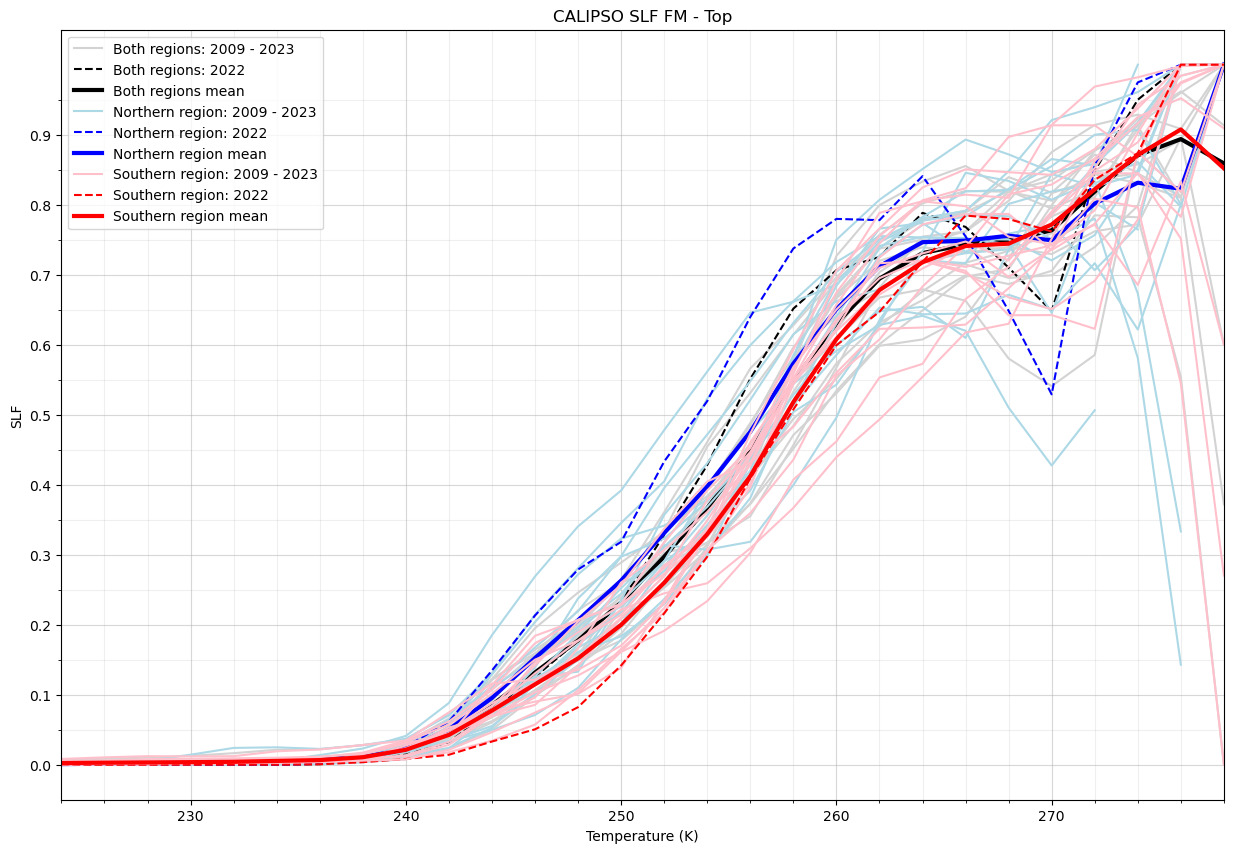

In [81]:
# FM Top

FMt_whole_ds = create_ds_with_attrs(fm_files[3], cal_path)
FMt_north_ds = create_ds_with_attrs(fm_files[4], cal_path)
FMt_south_ds = create_ds_with_attrs(fm_files[5], cal_path)

months = FMt_north_ds.attrs['months']

# --- Set up figure
fig, ax = plt.subplots(1,1,figsize=(15, 10))

if FMt_north_ds.attrs['cloudtop']:
    titex = ' - Top'
else:
    titex = ''

ax.set_title(f'CALIPSO SLF {months}{titex}')

for ds in [FM_whole_ds,FM_north_ds,FM_south_ds]:
    # calculate slf percent
    ds['slf_perc'] = ds['slf']/ds ['count']
    
    # get information for plots from attributes
    plot_info = get_plot_info(ds.attrs['region'])
    # plot for whole dataset (black)
    for year in ds['year']:
        if year == 2022:
            l = f'{plot_info.text}: 2022'
            col = plot_info.col1
            line='--'
        elif year == np.min(ds['year']).values:
            l = f'{plot_info.text}: {np.min(ds['year']).values} - {np.max(ds['year']).values}'
            col = plot_info.col2
            line='-'
        else:
            l='_nolegend_'
            col = plot_info.col2
            line='-'
        ax.plot(ds['temperature'],ds['slf_perc'].where(ds['year']==year, drop=True)[0], c=col,ls=line, label=l)
    
    # Plot the mean of all the years
    mean_ds = ds['slf_perc'].mean(dim='year')
    ax.plot(mean_ds['temperature'],mean_ds, label = f'{plot_info.text} mean', c=plot_info.col1, lw=3)


ax.set_ylabel(f'SLF')
ax.set_xlabel(f'Temperature (K)')
ax.legend()

ax.grid(True) 
# Gridline adjustments
major_ticks_y = np.arange(0, 1, 0.1) 
minor_ticks_y = np.arange(0, 1, 0.05)

major_ticks_x = np.arange(220, 281, 10)
minor_ticks_x = np.arange(220, 281, 2)

ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)
#-------
ax.set_xlim(ds['temperature'].min(), ds['temperature'].max())
plt.savefig(f'calipso_slf_{months}{titex}.png')
plt.show()

In [78]:
FMt_north_ds.slf.values

array([[   0,    3,   19,   33,   50,   61,   75,  106,  186,  308,  501,
         965, 1453, 2093, 2395, 2952, 3325, 3245, 2726, 2037, 1473,  914,
         422,  160,   24,    0,    0,    0],
       [   0,    0,    0,    3,    8,    9,   12,   43,  162,  369,  658,
        1039,  926, 1790, 3082, 3833, 4420, 4583, 4114, 3095, 2244, 1448,
         798,  346,  124,   11,    0,    0],
       [   3,    9,    9,   11,   47,   69,   88,  110,  158,  329,  538,
         763,  931, 1146, 1405, 1594, 1994, 2311, 2679, 2413, 2045, 1318,
         842,  485,  299,  143,   31,    0],
       [  10,    9,   10,    9,   10,   15,   18,   38,  145,  367,  705,
        1081, 1290, 1435, 1700, 2069, 2546, 2806, 3536, 3562, 3354, 2309,
        1375,  897,  409,  129,   28,    1],
       [  27,   27,   27,   63,  105,  135,  157,  178,  341,  978, 1663,
        2352, 2853, 3575, 3412, 3272, 3055, 3284, 3206, 2571, 2034, 1374,
        1124,  941,  536,  147,    1,    0],
       [   0,   20,   18,   20,   2